# Make Moons

Sklearn's *make_moons* dataset experimentation using Pytorch

In [0]:
import itertools
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.optim as optim

## Constants

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_samples = 3000
epochs = 200
batch_size = 64

## Data visualization

In [3]:
X, y = make_moons(n_samples=n_samples, shuffle=True, noise=0.1, random_state=None)

print(X.shape, y.shape)

(3000, 2) (3000,)


The make moons dataset contains:

- X: (x, y) coords
- y: label

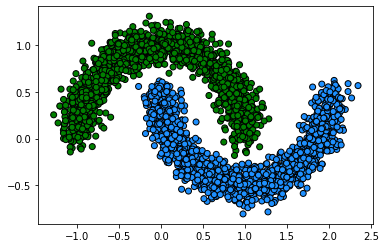

In [4]:
fcolors = ListedColormap(['green', 'dodgerblue'])
x_coords, y_coords = X[:, 0], X[:, 1]

plt.scatter(x_coords, y_coords, c=y, cmap=fcolors, edgecolors='black')

## Dataset & Dataloader

In [0]:
class MakeMoonsDataset(torch.utils.data.Dataset):

  def __init__(self, X, y):
    self.X = X
    self.y = y
  
  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=46)

train_dataset = MakeMoonsDataset(X_train, y_train)
val_dataset = MakeMoonsDataset(X_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

## Neural Network

We have a two dimensional input (x and y coordenates), we'll pass this input trough three dense layers, the first two have dim 3 and activation Relu, the last one dim 1 (our output) and activation sigmoid, as we have a binary classification.

In [6]:
input_dim = 2   # (x,y) coords
hidden_dim = 6  # dense layers dimensions
output_dim = 1  # result dimension

class Model(nn.Module):

  def __init__(self, input_shape, hidden_shape, output_shape):
    super(Model, self).__init__()
    # initialize layers
    self.hidden_1 = nn.Linear(input_shape, hidden_shape)
    self.hidden_2 = nn.Linear(hidden_shape, int(hidden_shape/2))
    self.output = nn.Linear(int(hidden_shape/2), output_shape)
  
  def forward(self, x):
    # define fordward behavior
    # used when a tensor is passed through the net
    x = self.hidden_1(x)
    x = torch.relu(x)
    x = self.hidden_2(x)
    x = torch.relu(x)
    x = self.output(x)
    x = torch.sigmoid(x)
    return x
  

# init model
model = Model(input_shape=input_dim,
              hidden_shape=hidden_dim,
              output_shape=output_dim)


# show model summary
model

Model(
  (hidden_1): Linear(in_features=2, out_features=6, bias=True)
  (hidden_2): Linear(in_features=6, out_features=3, bias=True)
  (output): Linear(in_features=3, out_features=1, bias=True)
)

Let's define functions for training and validation

In [0]:
def train_epoch(model, data_loader, criterion, optimizer, device):
  model.train()
  model.to(device)

  # init step loss & accuracty
  epoch_loss, epoch_acc = 0., 0.

  for x, y in data_loader:
    x, y = x.to(device).float(), y.to(device).float()

    # forward the input through the net
    out = model(x)
    y = y.unsqueeze(-1)

    # get loss & accuracy
    loss = criterion(out, y)
    with torch.no_grad():
      acc = torch.sum(torch.round(out) == y)
    
    # optimize model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # save loss & acc
    epoch_loss += loss.item() * y.size(0)
    epoch_acc += acc
  
  epoch_loss /= len(data_loader.dataset)
  epoch_acc /= len(data_loader.dataset)

  return epoch_loss, epoch_acc


def validate_epoch(model, data_loader, criterion, device):
  model.eval()
  model.to(device)

  epoch_loss, epoch_acc = 0., 0.

  with torch.no_grad():
    for x, y in data_loader:
      x, y = x.to(device).float(), y.to(device).float()

      # forward the input through the net
      out = model(x)
      y = y.unsqueeze(-1)

      # get & save loss & accuracy
      loss = criterion(out, y)
      acc = torch.sum(torch.round(out) == y)
      epoch_loss += loss.item() * y.size(0)
      epoch_acc += acc
  
  epoch_loss /= len(data_loader.dataset)
  epoch_acc /= len(data_loader.dataset)

  return epoch_loss, epoch_acc

### Train

In [8]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for e in tqdm(range(epochs)):
  train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
  val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)


print(f'Final => train_loss {train_losses[-1]:.3f} train_acc {train_accuracies[-1]:.3f} val_loss {val_losses[-1]:.3f} val_acc {val_accuracies[-1]:.3f}')


Final => train_loss 0.013 train_acc 0.998 val_loss 0.009 val_acc 0.999


### Plot the training history

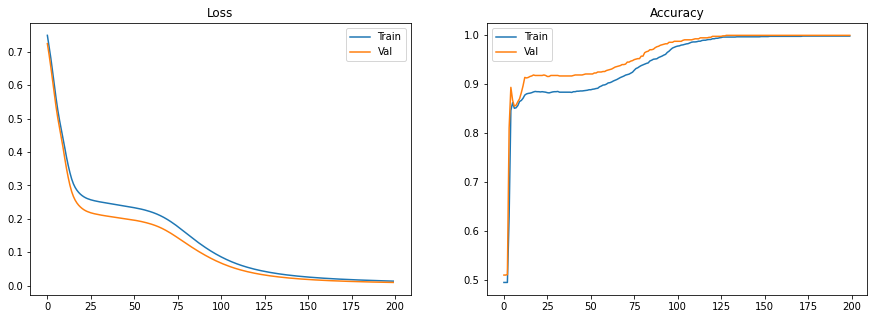

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Loss')
ax[0].plot(train_losses, label='Train')
ax[0].plot(val_losses, label='Val')
ax[0].legend()

ax[1].set_title('Accuracy')
ax[1].plot(train_accuracies, label='Train')
ax[1].plot(val_accuracies, label='Val')
ax[1].legend()

plt.show()

### Let's test our model with a new make_moons!

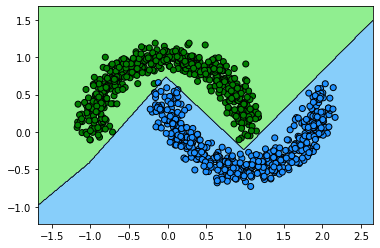

In [10]:
def predict(model, X, device):
  model.eval()
  model.to(device)
  X = torch.Tensor(X).to(device)
  with torch.no_grad():
    Y = model(X)
  return Y.round().cpu().detach().numpy()

# create test data
x_test, y_real = make_moons(n_samples=1000, noise=0.1, random_state=46)

# predict
y_test = predict(model, x_test, device)

# generate a grid to predict
x_min, x_max = x_test[:, 0].min() - .5, x_test[:, 0].max() + .5
y_min, y_max = x_test[:, 1].min() - .5, x_test[:, 1].max() + .5
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# predict the whole gid
Z = predict(model, np.c_[xx.ravel(), yy.ravel()], device)
Z = Z.reshape(xx.shape)

# plot the contour and examples
scatter_colors = ListedColormap(['green', 'dodgerblue'])
contour_colors = ListedColormap(['lightgreen', 'lightskyblue'])

plt.contourf(xx, yy, Z, cmap=contour_colors)
plt.contour(xx, yy, Z, colors=['black'], linewidths=0.2)
plt.scatter(x_test[:,0], x_test[:,1], c=y_real, cmap=scatter_colors, edgecolors='black')